# **Autoencoders in Computer Vision - Jupyter Notebook Tutorial**

# Section 1: Introduction to Autoencoders


NOTES:
Autoencoders are neural networks designed to learn compressed representations of data.
They work by encoding the input into a latent space and then decoding it back to reconstruct the input.

This is useful in scenarios where labeled data is scarce but we still want to learn meaningful features.
The learned features (latent vectors) are useful for:
- Image compression
- Noise reduction (denoising autoencoders)
- Anomaly detection (reconstruction error)
- Pretraining for classification or generative models
- Transfer learning


# Section 2: Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Section 3: Load Dataset (MNIST)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Section 4: Define Basic Autoencoder

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Section 5: Training Autoencoder

In [5]:
epochs = 5
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/5, Loss: 0.0207
Epoch 2/5, Loss: 0.0119
Epoch 3/5, Loss: 0.0099
Epoch 4/5, Loss: 0.0070
Epoch 5/5, Loss: 0.0076


# Section 6: Visualize Reconstruction

In [8]:
def show_reconstruction():
    model.eval()
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            outputs = model(images)
            break

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images[0].cpu().squeeze(), cmap='gray')
    axes[0].set_title("Original")
    axes[1].imshow(outputs[0].cpu().squeeze(), cmap='gray')
    axes[1].set_title("Reconstructed")
    plt.show()


 After visualizing the reconstructed images, the goal is to evaluate how well the model learned the compressed representation.
    If the reconstruction is good, it means the encoder has captured the essential information.

    These latent features can now be reused:
    - For clustering similar images
    - As inputs to a classifier
    - As building blocks for generative models like Variational Autoencoders or GANs

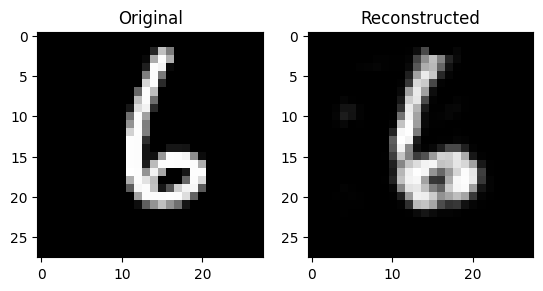

In [7]:
show_reconstruction()

# Section 7: Classification Using Latent Features

We now use the encoder's output (latent vector) to train a simple classifier.
This demonstrates the power of unsupervised representation learning.

In [9]:
class LatentClassifier(nn.Module):
    def __init__(self):
        super(LatentClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, z):
        return self.fc(z)

classifier = LatentClassifier().to(device)
clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Train the classifier using frozen encoder

In [10]:
model.eval()
for param in model.parameters():
    param.requires_grad = False

# Classification training loop

In [11]:
epochs = 5
for epoch in range(epochs):
    classifier.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            z = model.encoder(images)
        preds = classifier(z)
        loss = clf_criterion(preds, labels)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

    print(f"[Classifier] Epoch {epoch+1}, Loss: {loss.item():.4f}")

[Classifier] Epoch 1, Loss: 0.7055
[Classifier] Epoch 2, Loss: 0.1439
[Classifier] Epoch 3, Loss: 0.1071
[Classifier] Epoch 4, Loss: 0.0567
[Classifier] Epoch 5, Loss: 0.0756


# Evaluate classifier

In [12]:
correct, total = 0, 0
classifier.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        z = model.encoder(images)
        preds = classifier(z)
        predicted = preds.argmax(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy using latent features: {100 * correct / total:.2f}%")

Validation Accuracy using latent features: 95.23%


# Final Notes:

We explored basic and masked autoencoders in this notebook.
They enable learning rich visual representations without any labels.

By training to reconstruct input images or masked portions,
autoencoders learn **meaningful features** that capture underlying structure in the data.
These features can be used as a foundation for other computer vision tasks:
- Classification (as demonstrated)
- Clustering
- Generative Modeling (e.g. VAEs, GANs)